In [1]:
%config Completer.use_jedi = False # in case your autocomplete does not work

Now it's time to return to our deep learning topic. This time, we are gonna use a fully connected deep neural network for handwritten digit classification from MNIST. 

# Load Dataset

Unfortunately you need to go through this boring step first!

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets, transforms

In [3]:
tf_resize = transforms.Resize((28,28)) # make sure that all loaded images have these dimensions
tf_totensor = transforms.ToTensor() # Why? pytorch uses this datatype
tf_normalize = transforms.Normalize(mean=(.5,),std=(.5,)) # this is rather tricky to explain. I'll explain it after we compose all these transformations

tf_compose = transforms.Compose([tf_resize,tf_totensor,tf_normalize])

# This is how you read this concatenation of transformations.
# The output image will have the dimensions of 28x28 with the datatype of Tensor,
# and the range of value is from -1 to 1. 
# The range value from -1 to 1 is due to the Normalization.
# Why -1 to 1? Curious? I'll give you a chance to figure it out yourself
# Stuck? we can have a chat

# transforms.ToTensor gives the range of 0 to 1.
# Now if you do this, (v-mean)/std then you will have the range of -1 to 1, 
# where the value of v is from 0 to 1


In [4]:
training_set = datasets.MNIST(root='./',download=True,train=True, transform=tf_compose) # don't forget to transform it
test_set = datasets.MNIST(root='./',download=True,train=False, transform=tf_compose)

training_loader = torch.utils.data.DataLoader(
    dataset=training_set, 
    batch_size=4,
    shuffle=True, # good for training
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_set, 
    batch_size=4,
    shuffle=False, # not relevant for testing
)

Let's load one batch and investigate

In [5]:
training_set_iter = iter(training_loader)
batch = training_set_iter.next() # this loads the first batch

first_tensor = batch[0][0]
first_label = batch[1][0]

print("the first label is ", first_label)

the first label is  tensor(7)


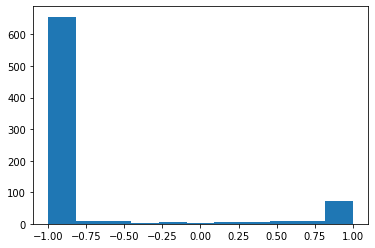

In [6]:
# let's check the histogram
# you should see the range from -1 to 1

plt.hist(np.ravel(first_tensor.numpy()), bins='auto'); 

In [7]:
# anyway, in case you need to display it, we need to cast it back to numpy and de-normalize it

def tensor_to_numpy(x):
    # it is important to clone the tensor so that we won't accidentally change the original data
    y = x.clone().detach().numpy()

    # check the size
    # y.size() will output something like torch.Size([1, 28, 28])
    # so we need to rearrange it
    y = y.transpose(1,2,0)
    
    # denormalize
    y = y*np.array([.5,.5,.5]) + np.array([.5,.5,.5])
    
    return y

Then, we can plot it.

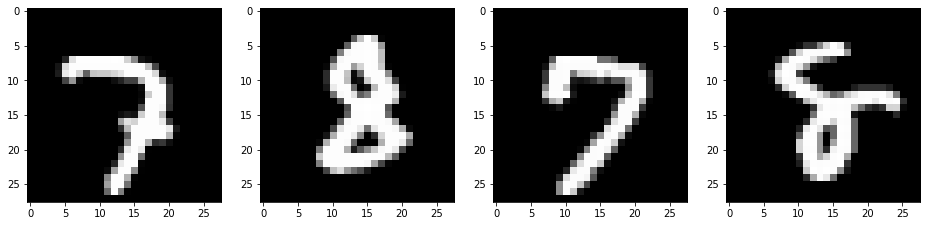

In [8]:
plt.figure(figsize=(16,9))

for idx,data in enumerate(batch[0]):
    plt.subplot(1,4,idx+1)
    plt.imshow(tensor_to_numpy(data))

# NN Model

We are going to use a fully densed neural network with 2 hidden layers.

Activation functions that are used are RelU.

In [9]:
import torch.nn as nn

class FNN(nn.Module):
    
    def __init__(self, input_size, num_neurons_hidden1,  num_neurons_hidden2, output_size):
        super().__init__()
        self.input_layer = nn.Linear(input_size,num_neurons_hidden1)
        self.hidden_layer1 = nn.Linear(num_neurons_hidden1,num_neurons_hidden2)
        self.output_layer = nn.Linear(num_neurons_hidden2,output_size)
        
    def forward(self,x):
        y = nn.functional.relu(self.input_layer(x))
        y = nn.functional.relu(self.hidden_layer1(y))
        y = self.output_layer(y)
        return y
        
        # Note that we are going to use CrossEntropy loss criterion later
        # You can find it here (https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)
        # that it already contains softmax
        
        # Recall that for a multi-class classification we use softmax instead of sigmoid
        
        

In [10]:
try:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = FNN(784, 125, 65, 10).to(device)
except:
    model = FNN(784, 125, 65, 10)


print(model)

FNN(
  (input_layer): Linear(in_features=784, out_features=125, bias=True)
  (hidden_layer1): Linear(in_features=125, out_features=65, bias=True)
  (output_layer): Linear(in_features=65, out_features=10, bias=True)
)


In [11]:
# Redefine the loaders such that the batch size is big

training_loader = torch.utils.data.DataLoader(
    dataset=training_set, 
    batch_size=100,
    shuffle=True, # good for training
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_set, 
    batch_size=100,
    shuffle=False, # not relevant for testing
)

In [12]:
from tqdm.notebook import tqdm



loss_fun = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4)

num_epochs = 100

training_losses = []
test_losses = []

for i in tqdm(range(num_epochs)):
    
    training_loss_accumulated = 0. # temp var
    test_loss_accumulated = 0. # temp var
    
    # training
    for idx, (inputs, labels) in enumerate(training_loader):
        # we can process one batch in one sweep
        # first rearrange it such that the size is [batch_size, 28*28]
        inputs = inputs.view(inputs.shape[0],-1)
        
        try:
            # utilize cuda (if any)
            inputs = inputs.to(device)
            labels = labels.to(device)
        except:
            pass
        
        outputs = model.forward(inputs)
        
        loss = loss_fun(outputs,labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        training_loss_accumulated += loss.item()
        
    # validation 
    with torch.no_grad(): # to speed up
        for idx, (inputs, labels) in enumerate(test_loader):
            # we can process one batch in one sweep
            # first rearrange it such that the size is [batch_size, 28*28]
            inputs = inputs.view(inputs.shape[0],-1)
            
            try:
                # utilize cuda (if any)
                inputs = inputs.to(device)
                labels = labels.to(device)
            except:
                pass
            
            outputs = model.forward(inputs)
        
            loss = loss_fun(outputs,labels)
            
            test_loss_accumulated += loss.item()
        
    # logs    
    training_losses.append(training_loss_accumulated/len(training_loader)) # take the average
    test_losses.append(test_loss_accumulated/len(test_loader)) # take the average


  0%|          | 0/100 [00:00<?, ?it/s]

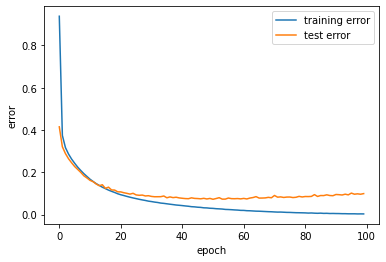

In [13]:
plt.plot(training_losses,label='training error')
plt.plot(test_losses,label='test error')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('error');

If you want to increase the number of epochs, you should see the gap between the training and the test errors widening. (If you are patient enough!)

Let's test it with one of test set.

In [14]:
test_set_iter = iter(test_loader)
batch = test_set_iter.next()

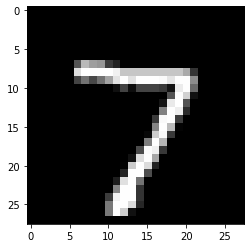

In [15]:
plt.imshow(tensor_to_numpy(batch[0][0]))

In [16]:
test_img = batch[0][0]
flatten_img = test_img.view(test_img.shape[0],-1)

In [17]:
try:
    result = torch.argmax(model.forward(flatten_img.to(device)))
except:
    result = torch.argmax(model.forward(flatten_img))

In [18]:
print(result)

tensor(7, device='cuda:0')
